In [1]:
# Models
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Mahine Learning Tools
from pmdarima import auto_arima
from sklearn.metrics import  mean_squared_error 
from sklearn.model_selection import TimeSeriesSplit

# Data Manipulation Tools
import pandas as pd
import numpy as np

# Data Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing Tools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

/home/iddhi/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Import the Dataset
priceData = pd.read_csv("./data/processed/pricesList.csv")
rainfallData = pd.read_csv("./data/processed/rainfallData.csv")

In [8]:
# set the index to the date
def extractDate(data):
    data2 = data.copy()
    data2["Datetime"] = pd.to_datetime(data2[['Year', 'Month']].assign(day=(data2["Week"]-1)*7 +1))
    data2 = data2.set_index('Datetime')
    return data2
priceData = extractDate(priceData)

## Visualize Dataset

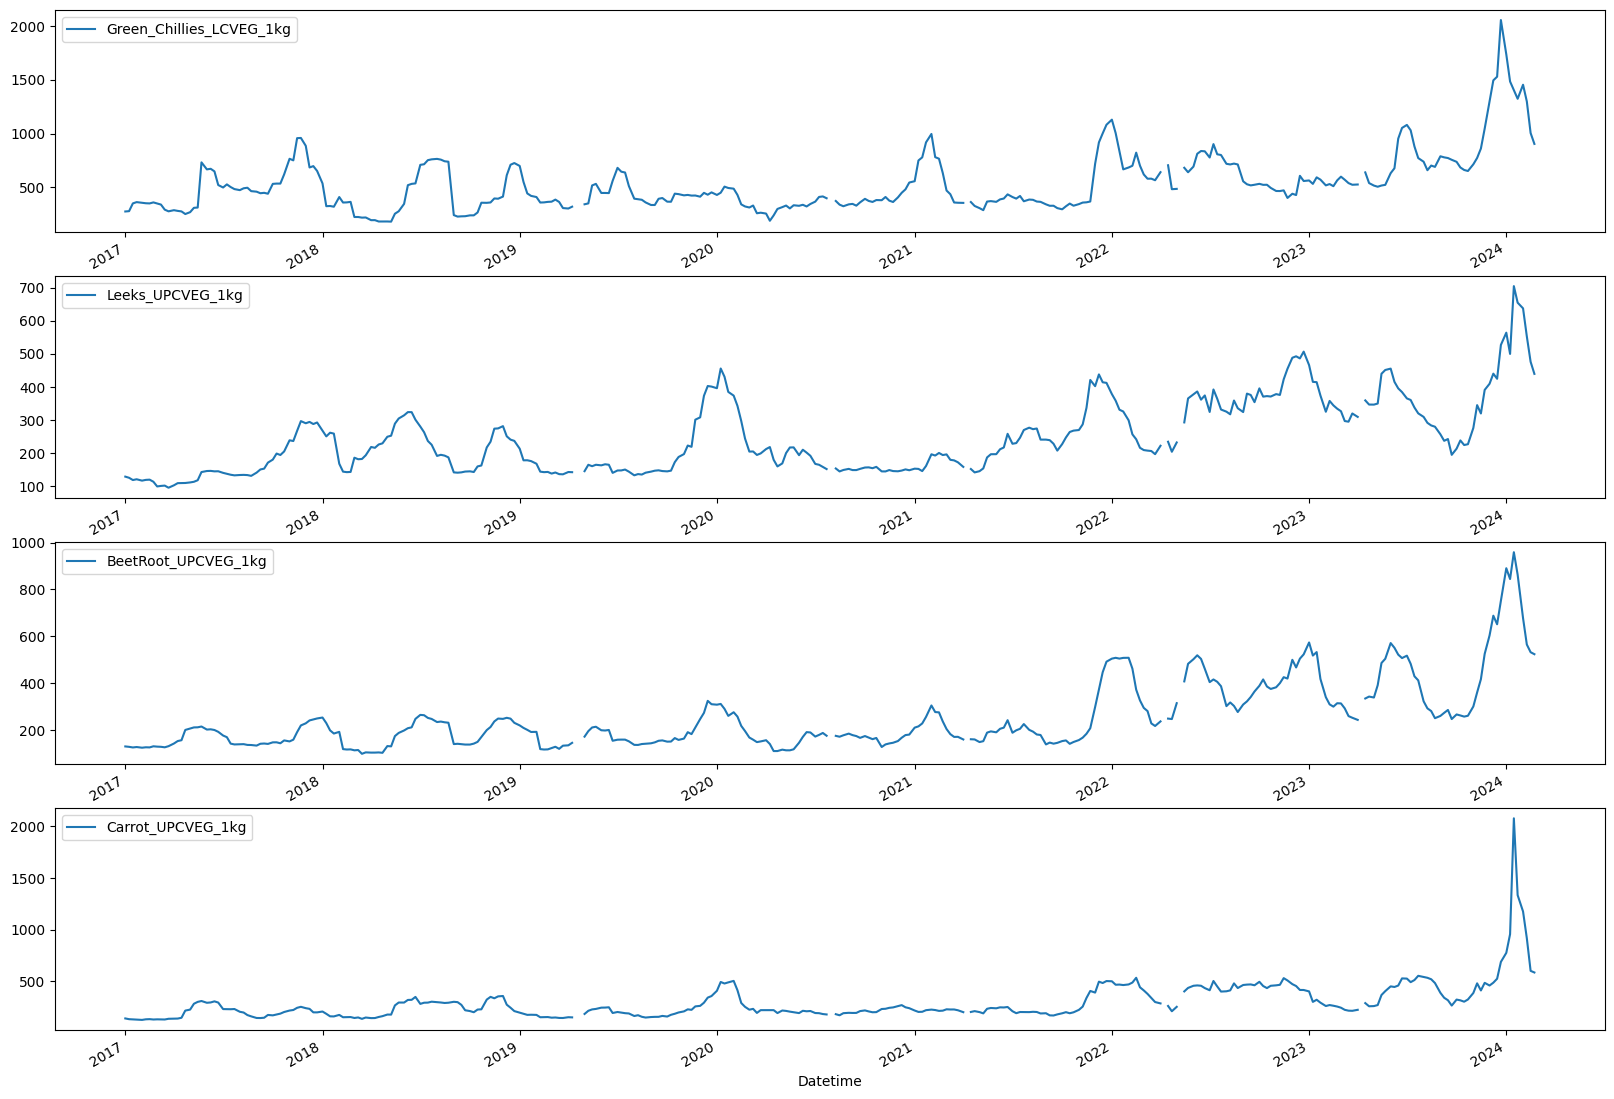

In [9]:
# Get all the unique values of the Name column in the dataset and iterate through them to display the price trend
uniqueNames = priceData['Name'].unique()
# fig with subplots for each name
fig, axs = plt.subplots(len(uniqueNames), 1, figsize=(20, 15))
for i, name in enumerate(uniqueNames):
    # filter the dataset to get the data for the current name
    priceData[priceData['Name'] == name]["Price"].plot(ax=axs[i], label=name)
    axs[i].legend(loc='upper left')
plt.show()

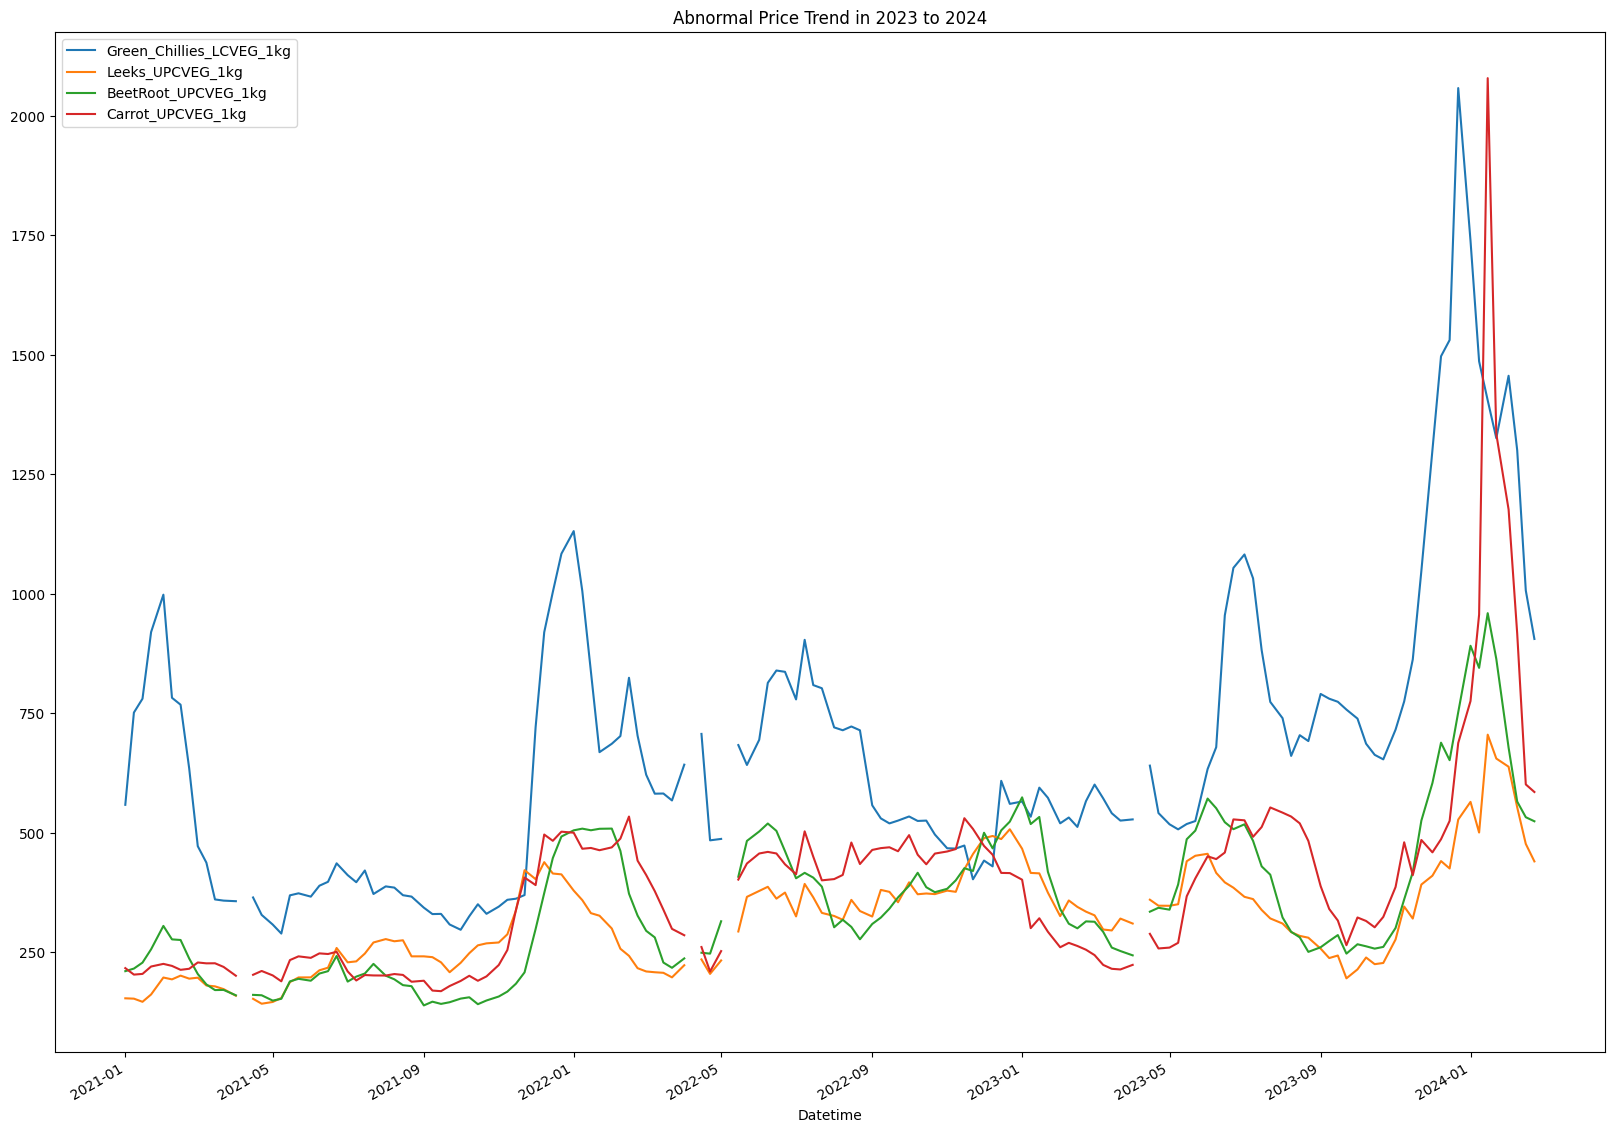

In [10]:

# fig with one plot for all names
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
for i, name in enumerate(uniqueNames):
    # filter the dataset to get the data for the current name from date 2016-01-01 to 2019-12-31
    priceData[priceData['Name'] == name]["Price"].loc['2021-01-01':'2024-12-31'].plot(ax=ax, label=name)
    ax.legend(loc='upper left')
plt.title("Abnormal Price Trend in 2023 to 2024")
plt.show()

## Extract Data

In [11]:
# create a new dataset for processing
df = priceData.copy()
# extract only one vegetable for the prediction
vegetable = uniqueNames[0]
df = df[df["Name"] == vegetable]
df.drop(columns=["Name"], inplace=True)

In [12]:
# merge the rainfall data with the price data
for index, row in rainfallData.iterrows():
    year = row['year']
    month = row['month']
    df.loc[(df['Year'] == year) & (df['Month'] == month), 'anuradhapura'] = row['anuradhapura']
    df.loc[(df['Year'] == year) & (df['Month'] == month), 'jaffna'] = row['jaffna']
    df.loc[(df['Year'] == year) & (df['Month'] == month), 'nuwaraeliya'] = row['nuwaraeliya']


## Simple Imputer

In [13]:
# Simple Imputer for missing values in the dataset
def imputeData(data, column):
    imputer = SimpleImputer(missing_values = pd.NA, strategy ='mean')
    imputer.fit(data[[column]])
    # round to 2 decimal places
    data[column] = imputer.transform(data[[column]])
    data[column] = data[column].round(2)

imputeData(df, "Price")
imputeData(df, "anuradhapura")
imputeData(df, "jaffna")
imputeData(df, "nuwaraeliya")

# drop the columns where price is null
df = df.dropna(subset=["Price"])

## Lag Features

In [14]:
def createLagFeatures(data, lag):
    data2 = data.copy()
    data2["Price_Lag"] = data2["Price"].shift(lag)
    data2["anuradhapura_Lag"] = data2["anuradhapura"].shift(lag)
    data2["jaffna_Lag"] = data2["jaffna"].shift(lag)
    data2["nuwaraeliya_Lag"] = data2["nuwaraeliya"].shift(lag)
    return data2
df = createLagFeatures(df, 1)

## Rolling Features

In [15]:
def createRollingFeatures(data, window):
    data2 = data.copy()
    data2["Price_Mean"] = data2["Price"].rolling(window=window).mean().shift(1)
    data2["anuradhapura_Mean"] = data2["anuradhapura"].rolling(window=window).mean().shift(1)
    data2["jaffna_Mean"] = data2["jaffna"].rolling(window=window).mean().shift(1)
    data2["nuwaraeliya_Mean"] = data2["nuwaraeliya"].rolling(window=window).mean().shift(1)
    return data2
df = createRollingFeatures(df, 3)


In [16]:
# Remove null values
df.dropna(inplace=True)

## Data Visualization

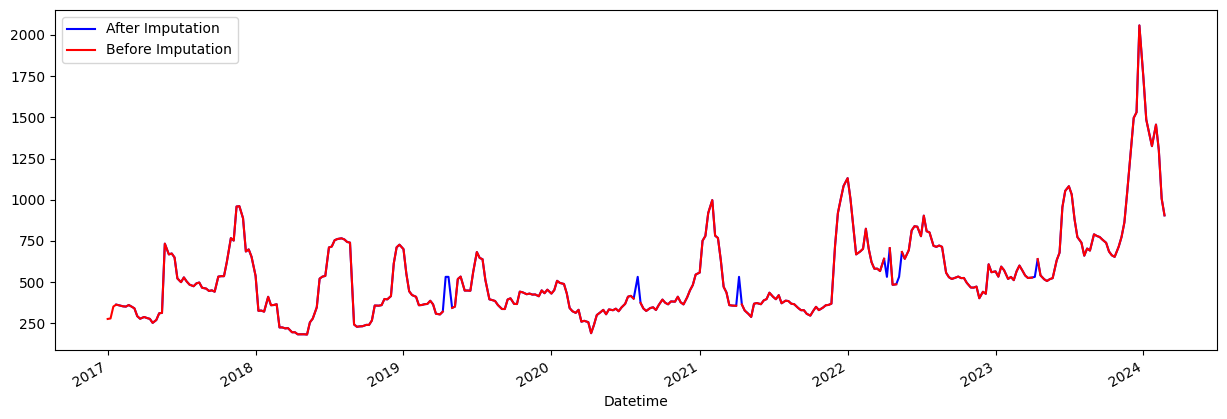

In [17]:
fix, ax = plt.subplots(1, 1, figsize=(15, 5))
df["Price"].plot(ax=ax, label="After Imputation", color="blue")
priceData[priceData["Name"] == vegetable]["Price"].plot(ax=ax, label="Before Imputation", color="red")
plt.legend(loc='upper left')

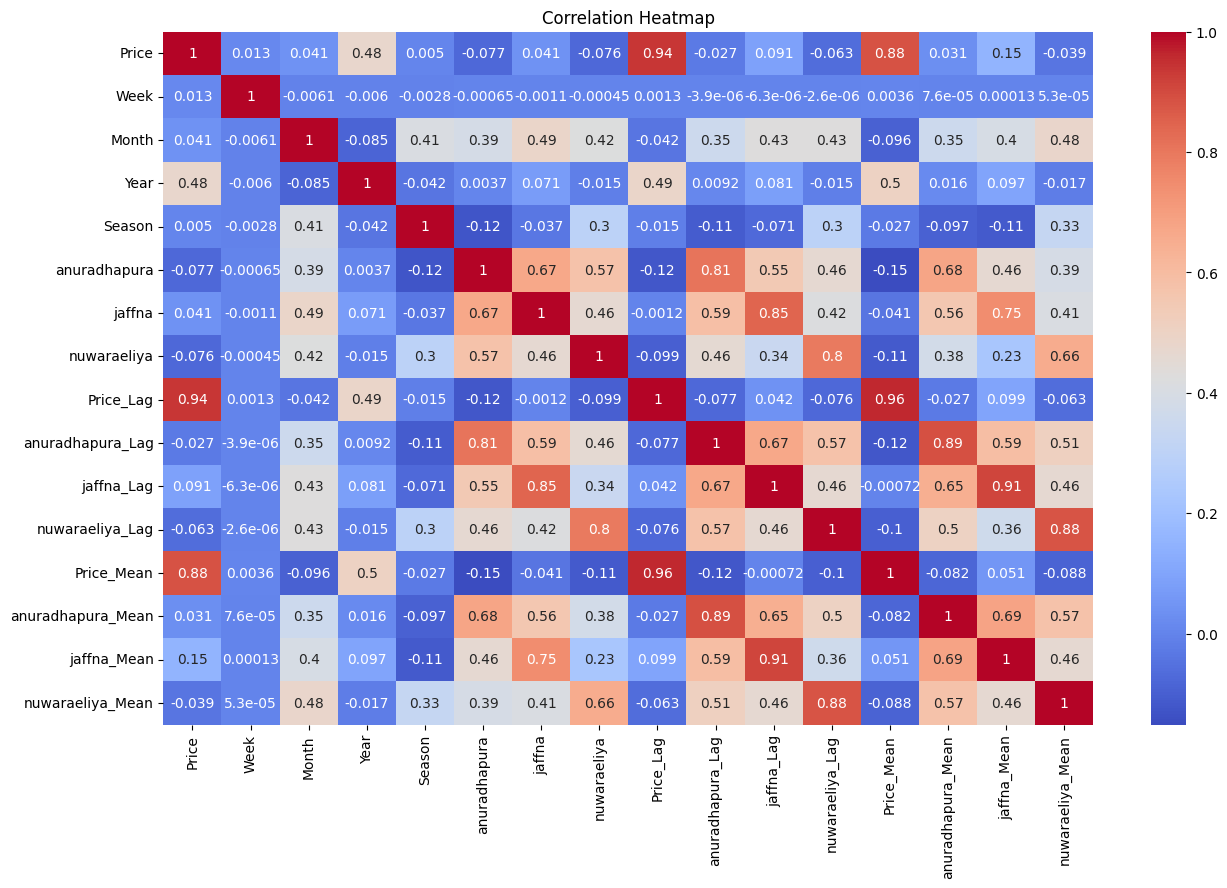

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
for column in df.select_dtypes(include=['object']).columns:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', ax=ax)
plt.title("Correlation Heatmap")
plt.show()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341 entries, 2017-01-22 to 2024-02-22
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              341 non-null    float64
 1   Week               341 non-null    int64  
 2   Month              341 non-null    int64  
 3   Year               341 non-null    int64  
 4   Season             341 non-null    int64  
 5   anuradhapura       341 non-null    float64
 6   jaffna             341 non-null    float64
 7   nuwaraeliya        341 non-null    float64
 8   Price_Lag          341 non-null    float64
 9   anuradhapura_Lag   341 non-null    float64
 10  jaffna_Lag         341 non-null    float64
 11  nuwaraeliya_Lag    341 non-null    float64
 12  Price_Mean         341 non-null    float64
 13  anuradhapura_Mean  341 non-null    float64
 14  jaffna_Mean        341 non-null    float64
 15  nuwaraeliya_Mean   341 non-null    float64
dtypes: floa

## Preprocess Data

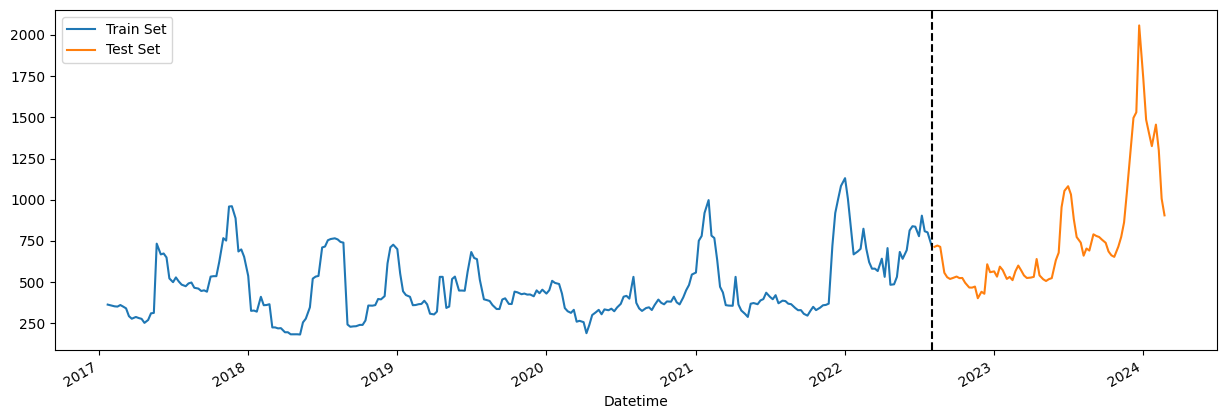

In [20]:
split_date = "2022-08-01"
train = df.loc[df.index <= split_date]
test = df.loc[df.index > split_date]
fix, ax = plt.subplots(1, 1, figsize=(15, 5))
train['Price'].plot(ax=ax, label="Train Set")
test['Price'].plot(ax=ax, label="Test Set")
ax.axvline(split_date, color="black", ls="--")
ax.legend("Training set", "Test Set")
plt.legend(loc='upper left')
plt.show()

In [21]:
# divide the dataset into features and target
FEATURES = ["Week", "Month", "Year",
            #"anuradhapura", "jaffna", "nuwaraeliya", 
            "Price_Lag", # "anuradhapura_Lag", "jaffna_Lag", "nuwaraeliya_Lag",
            "Price_Mean", # "anuradhapura_Mean", "jaffna_Mean", "nuwaraeliya_Mean"
        ]
TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Model Training & Evaluation

### Facebook Prophet

15:24:42 - cmdstanpy - INFO - Chain [1] start processing


15:24:42 - cmdstanpy - INFO - Chain [1] done processing


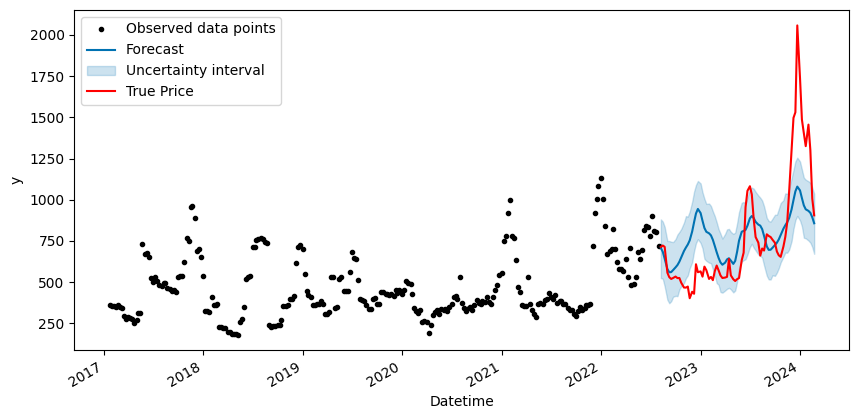

In [32]:
# Train the model
fb_prophet = Prophet()
fb_prophet.fit(train.reset_index().rename(columns={"Datetime": "ds", "Price": "y"}))

# Evaluate the model
prophet_pred = fb_prophet.predict(test.reset_index().rename(columns={"Datetime": "ds", "Price": "y"}))
fix, ax = plt.subplots(figsize=(10, 5))
fig = fb_prophet.plot(prophet_pred, ax=ax)
test["Price"].plot(ax=ax, label="True Price", color="r")
plt.legend(loc='upper left')
plt.show()

### XGB Regressor

MSE:  70732.74069417095
Score:  39.01744378183669


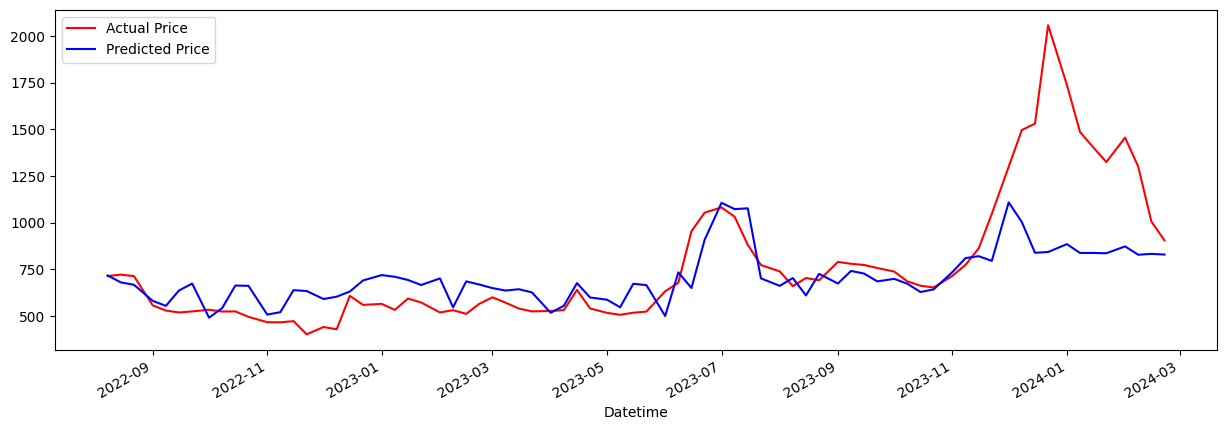

In [33]:
# Model Training
XGB_reg = XGBRegressor(n_estimators=2000, learning_rate=0.01)
XGB_reg.fit(X_train, y_train, early_stopping_rounds=2000, eval_set=[(X_test, y_test)], verbose=False)

# Evaluate the model
XGB_pred = XGB_reg.predict(X_test)
mse = mean_squared_error(y_test, XGB_pred)
score = XGB_reg.score(X_test, y_test)
print("MSE: ", mse)
print("Score: ", score*100)

fix, ax = plt.subplots(1, 1, figsize=(15, 5))
y_test.plot(ax=ax, label="Actual Price", color="red")
pd.Series(XGB_pred, index=y_test.index).plot(ax=ax, label="Predicted Price", color="blue")
plt.legend(loc='upper left')
plt.show()

### Random Forest Regressor

MSE:  49903.19991986477
Score:  56.97572772222319


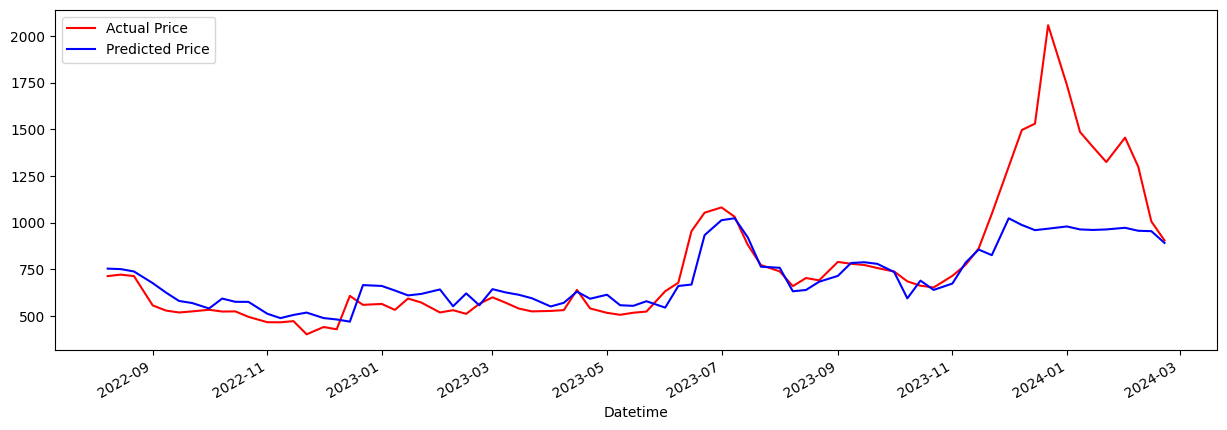

In [34]:
RF_reg = RandomForestRegressor(bootstrap=True, criterion='absolute_error',n_estimators=5000, random_state=None, verbose=False)
RF_reg.fit(X_train, y_train)

# Evaluate the model
RF_pred = RF_reg.predict(X_test)
mse = mean_squared_error(y_test, RF_pred)
score = RF_reg.score(X_test, y_test)
print("MSE: ", mse)
print("Score: ", score*100)

fix, ax = plt.subplots(1, 1, figsize=(15, 5))
y_test.plot(ax=ax, label="Actual Price", color="red")
pd.Series(RF_pred, index=y_test.index).plot(ax=ax, label="Predicted Price", color="blue")
plt.legend(loc='upper left')
plt.show()

### Cat Boost Regressor

MSE:  37264.6109713758
Score:  67.87214504615987


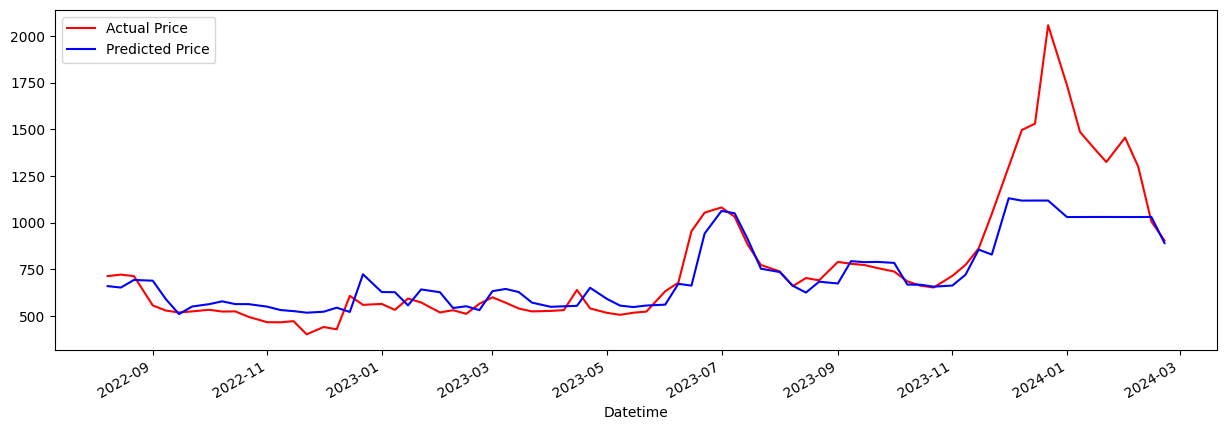

In [35]:
CB_reg =  CatBoostRegressor(iterations=100000, depth=1, learning_rate=0.001, loss_function='RMSE')
CB_reg.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

# Evaluate the model
CB_pred = CB_reg.predict(X_test)
mse = mean_squared_error(y_test, CB_pred)
score = CB_reg.score(X_test, y_test)
print("MSE: ", mse)
print("Score: ", score*100)

fix, ax = plt.subplots(1, 1, figsize=(15, 5))
y_test.plot(ax=ax, label="Actual Price", color="red")
pd.Series(CB_pred, index=y_test.index).plot(ax=ax, label="Predicted Price", color="blue")
plt.legend(loc='upper left')
plt.show()

### ARIMA Model

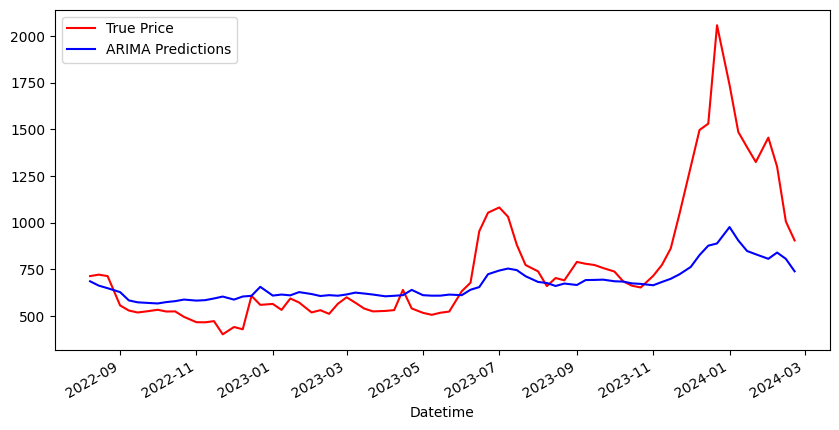

In [26]:
# find the best model
stepwise_fit = auto_arima(df["Price"], exogenous=train, seasonal=True, m=12, stepwise=True, error_action="ignore",max_p=3, max_q=3, max_P=3, max_Q=3,)
# Train the model
arima = SARIMAX(train[TARGET],exog=train[FEATURES], order=(stepwise_fit.get_params()["order"]),seasonal_order=(0, 0, 0, 0))
arima = arima.fit(maxiter=500, disp=False)
# Evaluate the model
start = len(train)
end = len(train) + len(test) - 1
arima_pred = arima.predict(start=start, end=end, typ="levels", exog=test[FEATURES]).rename("ARIMA Predictions")
arima_pred.index = test.index
fix, ax = plt.subplots(figsize=(10, 5))
test["Price"].plot(ax=ax, label="True Price", color="red")
arima_pred.plot(ax=ax, label="ARIMA Predictions", color="blue")
plt.legend(loc='upper left')
plt.show()


### All Model Evaluation

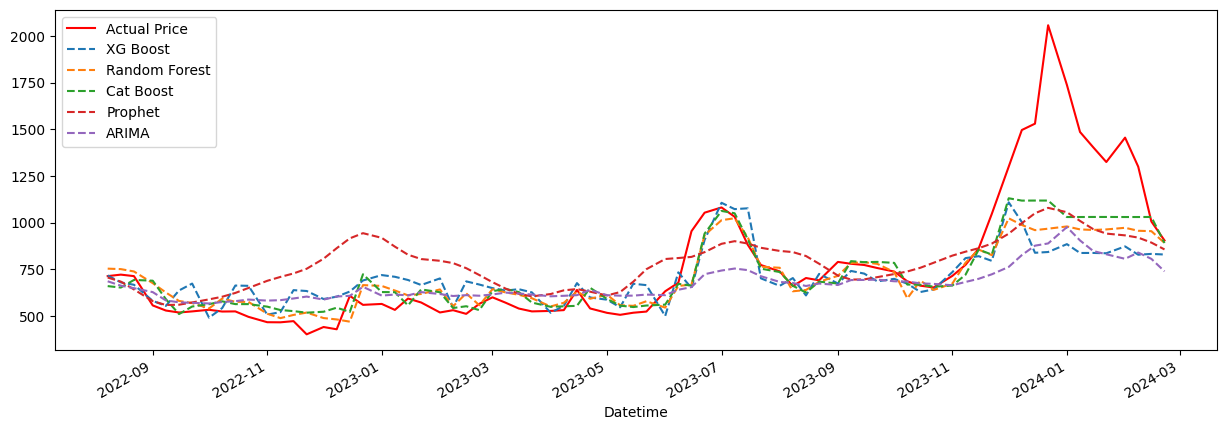

In [40]:
# Foreacast the price
prediction = test.copy()
prediction["XGB"] = XGB_pred
prediction["RF"] = RF_pred
prediction["CB"] = CB_pred
prediction["Prophet"] = prophet_pred["yhat"].values
prediction["ARIMA"] = arima_pred
ax = prediction["Price"].plot(label="Actual Price", figsize=(15, 5), color="red")
prediction["XGB"].plot(ax=ax, label="XG Boost", style="--")
prediction["RF"].plot(ax=ax, label="Random Forest",  style="--")
prediction["CB"].plot(ax=ax, label="Cat Boost",  style="--")
prediction["Prophet"].plot(ax=ax, label="Prophet",  style="--")
prediction["ARIMA"].plot(ax=ax, label="ARIMA",  style="--")
plt.legend(loc='upper left')
plt.show()

## Time Series Cross Validation

In [ ]:
# Time Series Cross Validation
splits = 6
tss = TimeSeriesSplit(n_splits=splits, test_size=5,gap=-1)
df2 = df.copy().sort_index()
fig, axs = plt.subplots(splits, 1, figsize=(15, 15))
fold = 0
for train_idx, test_idx in tss.split(df2):
    print("Prediction set " + str(fold+1) + " started")
    train_tss = df2.iloc[train_idx]
    test_tss = df2.iloc[test_idx]
    X_tss_train = train_tss[FEATURES]
    y_tss_train = train_tss[TARGET]
    X_tss_test = test_tss[FEATURES]
    y_tss_test = test_tss[TARGET]
    # plot train and test set
    train_tss["Price"].loc["2023-01-01":].plot(ax=axs[fold], label="Train Set", color="blue")
    test_tss["Price"].plot(ax=axs[fold], label="Test Set", color="red")

    # Train the models
    XGB_reg = XGB_reg.fit(X_tss_train, y_tss_train)
    RF_reg = RF_reg.fit(X_tss_train, y_tss_train)
    CB_reg = CB_reg.fit(X_tss_train, y_tss_train)
    arima = SARIMAX(train_tss[TARGET],exog=train_tss[FEATURES], order=(stepwise_fit.get_params()["order"]),seasonal_order=(0, 0, 0, 0))
    arima = arima.fit(maxiter=500, disp=False)

    # Evaluate the models
    XGB_pred = XGB_reg.predict(X_tss_test)
    RF_pred = RF_reg.predict(X_tss_test)
    CB_pred = CB_reg.predict(X_tss_test)
    arima_pred = arima.predict(start=len(train_tss), end=len(train_tss) + len(test_tss) - 1, typ="levels", exog=test_tss[FEATURES]).rename("ARIMA Predictions")
    arima_pred.index = test_tss.index

    # plot the predictions
    pd.Series(XGB_pred, index=y_tss_test.index).plot(ax=axs[fold], label="XG Boost", color="green", style="--")
    pd.Series(RF_pred, index=y_tss_test.index).plot(ax=axs[fold], label="Random Forest", color="blue", style="--")
    pd.Series(CB_pred, index=y_tss_test.index).plot(ax=axs[fold], label="Cat Boost", color="orange", style="--")
    arima_pred.plot(ax=axs[fold], label="ARIMA", color="black", style="--")
    axs[fold].legend(loc='upper left')
    
    fold += 1